In [1]:
import json 
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import re, nltk, spacy, string

nlp = spacy.load("C:/Users/rrraj/AppData/Roaming/Python/Python38/site-packages/en_core_web_sm/en_core_web_sm-3.0.0")
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [2]:
# Opening JSON file 
f = "complaints-2021-05-14_08_16.json"# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
with open(f,'r') as file:
    data = json.load(file)
df=pd.json_normalize(data)

In [3]:
#Assign new column names
df.rename(columns={'_index':'index', '_type':'type', '_id':'id', '_score':'score',
                    '_source.complaint_what_happened':'complaints_what_happened', '_source.product':'product',
                   '_source.zip_code':'zip_code','_source.complaint_id':'complaint_id', '_source.issue':'issue',
                  '_source.tags':'tags','_source.date_received':'date_received','_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed','_source.company_response':'company_response',
                  '_source.company':'company','_source.submitted_via':'submitted_via','_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product', '_source.timely':'timely', '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'}, inplace=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaints_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [4]:
#Assign nan in place of blanks in the complaints column
df['complaints_what_happened'].replace("", np.nan, inplace=True)

In [5]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints_what_happened'], inplace=True)

In [6]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_noisy_text(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [7]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [8]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaints_what_happened']] 
df_clean['lemmatized_complaints'] = df_clean['complaints_what_happened'].progress_apply(lambda x: lemmatize_text(x))

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [10:17<00:00, 34.10it/s]
C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\2963758196.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
#Write your function to extract the POS tags 

def get_pos_tag(text):
  # write your code here
    # Creating a textblob object
    text_blob = TextBlob(text)

    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])



df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaints'].progress_apply(lambda x: get_pos_tag(x))#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [06:00<00:00, 58.49it/s]
C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\1988406740.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
df_clean.head(5)

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...


In [12]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\3655474111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
#Write your code here to initialise the TfidfVectorizer 
tfid_vectorizer = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

In [15]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_features = tfid_vectorizer.fit_transform(df_clean['Complaint_clean'])

In [16]:
from sklearn.decomposition import NMF
import gensim
from gensim.corpora.dictionary import Dictionary

In [17]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10#write the value you want to test out

n_components = 4
init = "nndsvda"

#keep the random_state =40
nmf_model = NMF(
        n_components=n_components,
        random_state=1,
        init=init,
        beta_loss="frobenius",
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=1
    )

In [18]:
nmf_model.fit(tfidf_features)
len(tfid_vectorizer.get_feature_names())

C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6517

In [19]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfid_vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'fee', 'business', 'time', 'branch', 'claim', 'number', 'transaction', 'deposit', 'day', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['time', 'debt', 'year', 'account', 'application', 'limit', 'letter', 'information', 'balance', 'score', 'company', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['pay', 'day', 'fee', 'date', 'rate', 'statement', 'home', 'balance', 'year', 'modification', 'time', 'month', 'mortgage', 'loan', 'payment']


TOP 15 WORDS FOR TOPIC #3
['refund', 'month', 'time', 'company', 'service', 'balance', 'fraud', 'statement', 'purchase', 'transaction', 'merchant', 'card', 'dispute', 'fee', 'charge']




In [20]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(tfidf_features)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 0, 1, ..., 0, 2, 2], dtype=int64)

In [21]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)#write your code to assign topics to each rows.

C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\2035130174.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0: "Customer Details", 1: "Credit Card Details", 2: "Loan/Mortgage", 3: "Transactions"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\rrraj\AppData\Local\Temp\ipykernel_5424\2478337050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df_clean

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,Customer Details
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Customer Details
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,Credit Card Details
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit Card Details
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Customer Details
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,Credit Card Details
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,Customer Details
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,Customer Details
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...,credit yrs credit card xxxx problem balance tr...,credit yrs credit card problem balance transf...,Loan/Mortgage


In [213]:
training_data= df_clean[['complaints_what_happened','Topic']][:1000]

In [214]:

# #Write your code to get the Vector count
# count_vector=CountVectorizer()

# #Write your code here to transform the word vector to tf-idf
# X_train_count=count_vector.fit_transform(training_data['complaints_what_happened'])
# # tfidf_transform= TfidfTransformer()
# # X_train_tfidf = tfidf_transform.fit_transform(X_train_count).toarray() 
set(training_data['Topic'].to_list())

{'Credit Card Details', 'Customer Details', 'Loan/Mortgage', 'Transactions'}

In [215]:
from keras.utils import to_categorical

topic_dict = {topic: i for i, topic in enumerate(training_data['Topic'].unique())}

# Replace the string values in the 'Topic' column with the corresponding integer values
y_train_int = training_data['Topic'].map(topic_dict)

y_train_transformed = to_categorical(y_train_int, num_classes=4)

In [216]:
vectorizer = TfidfVectorizer().fit(training_data['complaints_what_happened'])
#vectorizer_label = TfidfVectorizer().fit(training_data['Topic'])

tfidf_vector_X = vectorizer.transform(training_data['complaints_what_happened']).toarray()  #//shape - (3,6)
# tfidf_vector_Y = vectorizer.transform(training_data.Topic).toarray() #//shape - (3,6)
tfidf_vector_X = tfidf_vector_X[:, :, None] #//shape - (3,6,1) 
# tfidf_vector_Y = tfidf_vector_Y[:, :, None] #//shape - (3,6,1)

In [217]:
y_train_transformed

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [218]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.20, random_state=42)

X_train_full, X_test, y_train_full, y_test = train_test_split(tfidf_vector_X, y_train_transformed, test_size = 0.2, random_state = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = 42)

In [219]:
X_train.shape, X_valid.shape

((640, 8275, 1), (160, 8275, 1))

In [220]:
y_valid[0].shape

(4,)

In [221]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(10, input_shape = X_train.shape[1:], return_sequences = True))
model.add(SimpleRNN(5))
model.add(Dense(units=4, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_56 (SimpleRNN)   (None, 8275, 10)          120       
                                                                 
 simple_rnn_57 (SimpleRNN)   (None, 5)                 80        
                                                                 
 output (Dense)              (None, 4)                 24        
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________
None


In [223]:
history = model.fit(X_train,y_train, epochs=10,
                     batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/10
10/10 [==============================] - 135s 13s/step - loss: 1.5749 - accuracy: 0.4437 - val_loss: 1.4518 - val_accuracy: 0.4688
Epoch 2/10
10/10 [==============================] - 131s 13s/step - loss: 1.4981 - accuracy: 0.4875 - val_loss: 1.4039 - val_accuracy: 0.4688
Epoch 3/10
10/10 [==============================] - 111s 11s/step - loss: 1.4446 - accuracy: 0.4875 - val_loss: 1.3701 - val_accuracy: 0.4688
Epoch 4/10
10/10 [==============================] - 93s 9s/step - loss: 1.4042 - accuracy: 0.4875 - val_loss: 1.3451 - val_accuracy: 0.4688
Epoch 5/10
10/10 [==============================] - 95s 9s/step - loss: 1.3725 - accuracy: 0.4875 - val_loss: 1.3266 - val_accuracy: 0.4688
Epoch 6/10
10/10 [==============================] - 96s 10s/step - loss: 1.3476 - accuracy: 0.4875 - val_loss: 1.3131 - val_accuracy: 0.4688
Epoch 7/10
10/10 [==============================] - 90s 9s/step - loss: 1.3276 - accuracy: 0.4875 - val_loss: 1.3029 - val_accuracy: 0.4688
Epoch 8/10
10

In [224]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

7/7 [==============================] - 3s 358ms/step - loss: 1.3378 - accuracy: 0.4450
Test Loss: 1.3378002643585205
Test Accuracy: 0.4449999928474426


In [107]:
sample_text = ['The movie was cool. The animation and the graphics ,were out of this world. I would recommend this movie.']
svc = vectorizer.transform(sample_text).toarray()
predictions = model.predict(svc)
predictions

1/1 [==============================] - 1s 584ms/step


array([[-0.85196275]], dtype=float32)

In [201]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

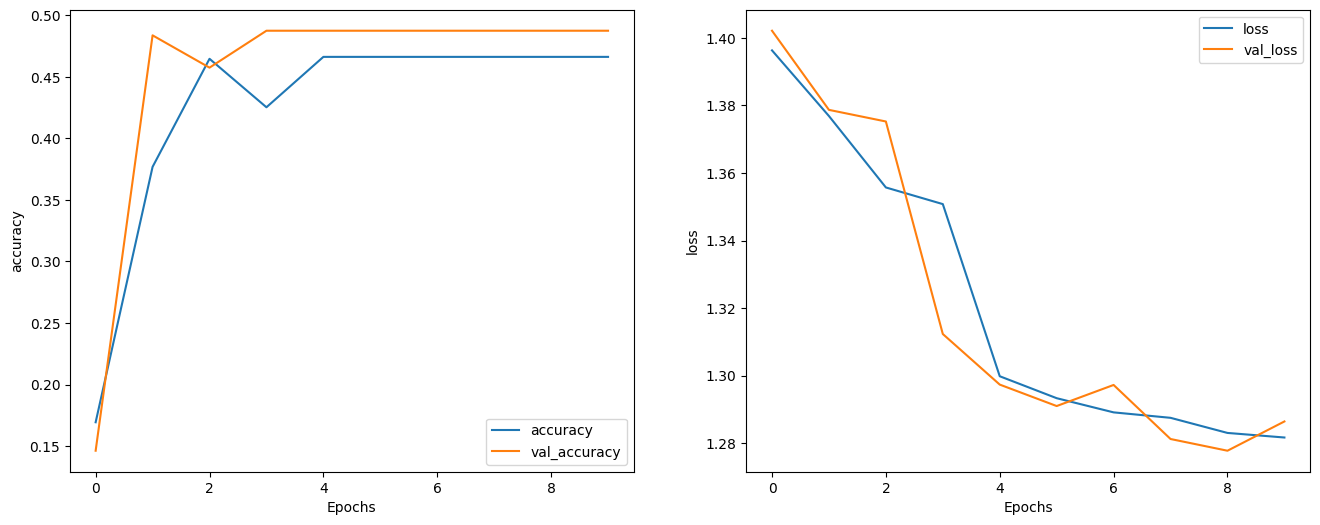

In [202]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [228]:
import os

model_version = "0001"
model_name = "C:\\upgrad assignments\\Model Deployment\\test_model_deploy"

model_path = os.path.join(model_name, model_version)

In [230]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: C:\upgrad assignments\Model Deployment\test_model_deploy\0001\assets


INFO:tensorflow:Assets written to: C:\upgrad assignments\Model Deployment\test_model_deploy\0001\assets


In [232]:
import requests
import json

In [255]:
input_data_json = json.dumps({
                            "signature_name": "serving_default",
                            "instances": X_valid.tolist()})

In [256]:
SERVER_URL = "http://localhost:8501/v1/models/1:predict"
response = requests.post(SERVER_URL, data=input_data_json)

In [257]:
response.raise_for_status()

In [258]:
response.json()

{'predictions': [[0.471549958, 0.135468408, 0.227466524, 0.16551514],
  [0.471570104, 0.135480464, 0.227593809, 0.165355548],
  [0.471309394, 0.135650337, 0.227549225, 0.16549103],
  [0.471526653, 0.135479897, 0.227455348, 0.165538207],
  [0.471640915, 0.135403454, 0.227483183, 0.165472358],
  [0.471544355, 0.135470614, 0.227461174, 0.165523887],
  [0.471555084, 0.135464683, 0.227467254, 0.165512934],
  [0.471473128, 0.135500729, 0.227405205, 0.165620893],
  [0.471272141, 0.135582089, 0.227264568, 0.165881261],
  [0.471544236, 0.135470539, 0.227460891, 0.165524304],
  [0.4715738, 0.135449782, 0.227467164, 0.165509194],
  [0.471685886, 0.135376871, 0.227504268, 0.16543296],
  [0.471788555, 0.135374457, 0.227764472, 0.16507256],
  [0.47134456, 0.135566235, 0.22733517, 0.165753946],
  [0.471546888, 0.13546969, 0.227463856, 0.165519506],
  [0.471571118, 0.135459736, 0.227485716, 0.165483505],
  [0.471549511, 0.135467514, 0.227463558, 0.165519372],
  [0.471498191, 0.135511458, 0.227501273, 